In [2]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
import corner
from IPython.display import display, Math
import pandas as pd
from decimal import Decimal, getcontext
import mpmath as mp

In [3]:
# define useful functions - for now Omg_k is zero

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

# sound horizon
def r_s_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), [a_min, 1/(1+z)])

# particle horizon
def r_hor_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x-1, cosmo)), [a_min, 1/(1+z)])

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Shift parameter
def R(cosmo,h):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.sqrt(Omg_m)*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]

# Acoustic scale
def l_A(cosmo,h):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.pi*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]/\
           (scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), 1e-2, 1/(1+z_CMB(Omg_b,Omg_m,h)))[0])

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [5]:
# try some values
cosmotry = [0.0453,0.027,0,9.227e-5,1e-20,0]
cosmotry_LCDM = [0.0453,0.027,0,9.227e-5,0,0]
h = 0.67
z_CMB_val = z_CMB(cosmotry[1],(cosmotry[0]+cosmotry[1]),h)
R_data = 1.74963 #\pm 5e-3 (assume no cross correlation - false)
l_a_data = 301.80845 #\pm 0.09
a_min = 0
mp.mp.dps = 3000

#print(r_s_fracH0c(z_CMB_val, cosmotry, a_min))
#print(np.pi*R_data/(l_a_data*np.sqrt(cosmotry[0]+cosmotry[1])))

In [168]:
#print(r_hor_fracH0c(z_CMB_val,cosmotry_LCDM, 0))
alim = 0 # approx planck scales
#print(r_hor_fracH0c(z_CMB_val,cosmotry, alim))
#print(r_hor_fracH0c(0,cosmotry, alim))
val = r_hor_fracH0c(z_CMB_val,cosmotry, alim)/(
    r_hor_fracH0c(0,cosmotry, alim) - r_hor_fracH0c(z_CMB_val,cosmotry, alim))
print(val*180/np.pi)

8.27871925441334235569749683847079410743824079805005373597474284014151018309475029347322145944735085763363966220697661008186698462685441410283438815805404217157522385095645008170435742160554964616830250540073546563405888604686481514927350930164634583298163740061478333171081390455389467569785971402549784656254816938229418675785542170473765604672929351095808918051308941490738508443361368043546617263582603865301139154399591351779519660944452034249081266660426191971438214841178721046605808480310312880007341091691439243365304160175208069865774237543577434775761972351879354729080137963265004036837800117852660038394028605419500795644255741186859137105821795312433255271626860090724654219541848273961997781198693866543715505004323194905065574560570579636198616968385063706525442328681227041875437085477078242605859193601289539064208231234292714158810493679067328143439705037170255241639070761255271795858442158774420771673807598298000588602815681233935419353396784654994889861131969699236481960619407

In [123]:
a_LCDM = np.linspace(1e-20,1e-1, int(1e3))
a = np.linspace(2e-9,1e-1, int(1e3))

r_horizon_LCDM = np.zeros(len(a))
r_horizon = np.zeros(len(a))

for i in range(len(a)):
    r_horizon[i] = r_hor_fracH0c(1/a[i] - 1 , cosmotry, 1e-9)
    r_horizon_LCDM[i] = r_hor_fracH0c(1/a_LCDM[i] - 1,cosmotry_LCDM, 0)


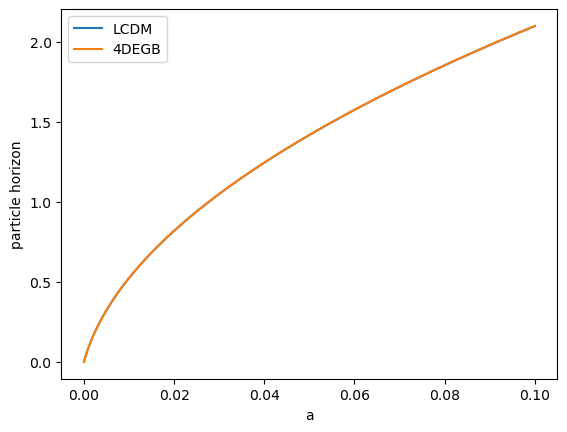

In [124]:
plt.plot(a_LCDM,r_horizon_LCDM, label = "LCDM")
plt.plot(a,r_horizon, label = "4DEGB")
#plt.plot(np.ones(int(1e2)), np.linspace(np.min(r_horizon),np.max(r_horizon), int(1e2)), "k--", label = "today")

plt.xlabel("a")
plt.ylabel("particle horizon")
plt.legend()

[480]


Text(0, 0.5, '$(aH)^{-1} [h^{-1}$Mpc]')

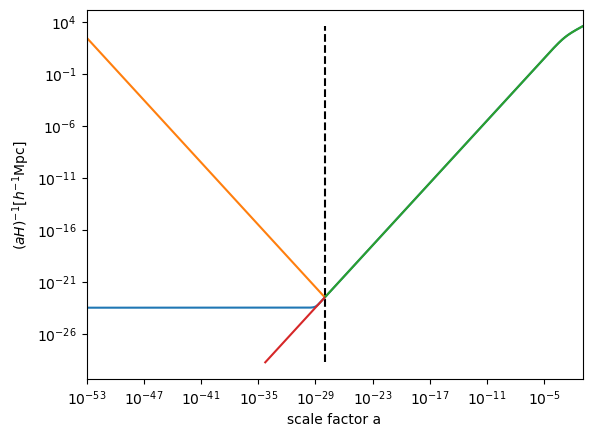

In [169]:
# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),Decimal('0'),Decimal('0')]
    
a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

plt.plot((alpha_t)**(Decimal('0.25'))*np.ones(len(a[int(3*idx_a_e/4):]),dtype=np.dtype(Decimal)), \
         Decimal('3e3')/(a[int(3*idx_a_e/4):]*E(1/a[int(3*idx_a_e/4):] - 1 , cosmotry_LCDM)), "k--")

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.plot(a, Decimal('3e3')/(a*E(1/a - 1 , cosmotry)))

print([idx_a_e])
plt.plot(a[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e])
plt.plot(a[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)))
plt.plot(a[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)))

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel("scale factor a")
plt.ylabel(r"$(aH)^{-1} [h^{-1}$Mpc]")

[480]


Text(0, 0.5, '$(aH)^{-1} [h^{-1}$Mpc]')

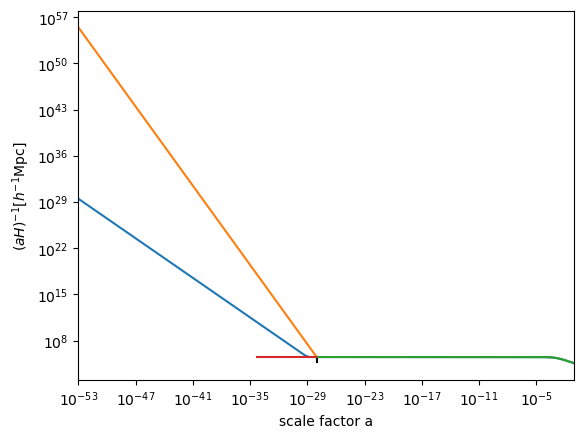

In [125]:
# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),Decimal('0'),Decimal('0')]
    
a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

plt.plot((alpha_t)**(Decimal('0.25'))*np.ones(len(a[int(3*idx_a_e/4):]),dtype=np.dtype(Decimal)), \
         Decimal('3e3')/(a[int(3*idx_a_e/4):]**2*E(1/a[int(3*idx_a_e/4):] - 1 , cosmotry_LCDM)), "k--")

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.plot(a, Decimal('3e3')/(a**2*E(1/a - 1 , cosmotry)))

print([idx_a_e])
plt.plot(a[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e]**2)
plt.plot(a[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]**2*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)))
plt.plot(a[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]**2*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)))

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel("scale factor a")
plt.ylabel(r"$(aH)^{-1} [h^{-1}$Mpc]")

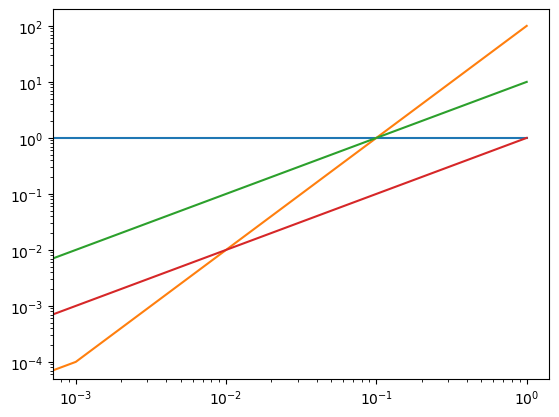

In [23]:
a_test = np.linspace(0,1,int(1e3))
plt.plot(a_test, np.ones(len(a_test)))
plt.plot(a_test, 100*a_test**2)
plt.plot(a_test, 10*a_test)
plt.plot(a_test, a_test)

plt.xscale("log")
plt.yscale("log")